In [1]:
import requests

url = "https://services.sentinel-hub.com/oauth/token"
payload = {
    'client_id': '46ec721b-c885-47ba-bbcf-2d03642bf0d4',
    'client_secret': 'aSYXhKB8QfpPcwC7eGzBDg4uhbMVqkfm',
    'grant_type': 'client_credentials'
}

response = requests.post(url, data=payload)
access_token = ''
if response.status_code == 200:
    access_token = response.json().get('access_token')
    print("Access Token:", access_token)
else:
    print("Error:", response.json())

Access Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJ3dE9hV1o2aFJJeUowbGlsYXctcWd4NzlUdm1hX3ZKZlNuMW1WNm5HX0tVIn0.eyJleHAiOjE3MjI1MDgxOTcsImlhdCI6MTcyMjUwNDU5NywianRpIjoiNmZiY2IyZDEtM2ZhNS00OGFlLWIxMmItYjNiNDZkNTNiYjQzIiwiaXNzIjoiaHR0cHM6Ly9zZXJ2aWNlcy5zZW50aW5lbC1odWIuY29tL2F1dGgvcmVhbG1zL21haW4iLCJzdWIiOiJiZmU3ZjFhYS04NTQyLTRkNzAtODk5Yi04Y2YzYzgxNWZkYTkiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiI0NmVjNzIxYi1jODg1LTQ3YmEtYmJjZi0yZDAzNjQyYmYwZDQiLCJzY29wZSI6ImVtYWlsIHByb2ZpbGUiLCJlbWFpbF92ZXJpZmllZCI6ZmFsc2UsImNsaWVudEhvc3QiOiIxMTguNzAuMTUuMTEiLCJwcmVmZXJyZWRfdXNlcm5hbWUiOiJzZXJ2aWNlLWFjY291bnQtNDZlYzcyMWItYzg4NS00N2JhLWJiY2YtMmQwMzY0MmJmMGQ0IiwiY2xpZW50QWRkcmVzcyI6IjExOC43MC4xNS4xMSIsImFjY291bnQiOiJkOGVkNjIzYy02MGI4LTRmNTMtOTU2MC1iNzg5NjUwNzI2NWEiLCJjbGllbnRfaWQiOiI0NmVjNzIxYi1jODg1LTQ3YmEtYmJjZi0yZDAzNjQyYmYwZDQifQ.Mb7B_84Ivn4Q9acXGV1KzP8frNE3yyFtTjKt21M3AKiRqkBQuP3ieVaJka7y_zTL7dXBku6CAJXuQADPS6MVInSZu6Cv--YRPMideXpDnUMkGnsk8tDT-SioCm4sO6x2BsXq6mCmLdB-BsaRklTzvG2_urzWPvwqNeSTUPc3-2k

In [2]:
import requests
import json
from datetime import datetime, timedelta

# Thay thế bằng access token đã lấy được
ac = access_token

# Cấu hình
API_URL = 'https://services.sentinel-hub.com/api/v1/process'
HEADERS = {
    'Authorization': f'Bearer {ac}',
    'Content-Type': 'application/json'
}

# Cấu hình bounding box và evalscript
bbox = [13.822, 45.850, 14.559, 46.291]
evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B02", "B03", "B04"],
            output: { bands: 3 }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

# Hàm để tải xuống và lưu ảnh
def download_image(start_date, end_date, index):
    request_payload = {
          "input": {
            "bounds": {
              "geometry": {
                "type": "Polygon",
                "coordinates": [
                  [
                    [
                      108.121626,
                      13.90695
                    ],
                    [
                      108.123708,
                      13.905867
                    ],
                    [
                      108.121755,
                      13.902118
                    ],
                    [
                      108.119631,
                      13.903055
                    ],
                    [
                      108.121626,
                      13.90695
                    ]
                  ]
                ]
              }
            },
            "data": [
              {
                "dataFilter": {
                  "timeRange": {
                    "from": "2024-07-01T00:00:00Z",
                    "to": "2024-08-01T23:59:59Z"
                  }
                },
                "type": "sentinel-2-l2a"
              }
            ]
          },
          "output": {
            "width": 512,
            "height": 625.126,
            "responses": [
              {
                "identifier": "default",
                "format": {
                  "type": "image/jpeg"
                }
              }
            ]
          },
          "evalscript": "//VERSION=3\n\nfunction setup() {\n  return {\n    input: [\"B02\", \"B03\", \"B04\"],\n    output: { bands: 3 }\n  };\n}\n\nfunction evaluatePixel(sample) {\n  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];\n}"
        }

    response = requests.post(API_URL, headers=HEADERS, data=json.dumps(request_payload))

    if response.status_code == 200:
        with open(f'img/output_{index}.tiff', 'wb') as f:
            f.write(response.content)
        print(f"Dữ liệu đã được tải xuống thành công cho khoảng thời gian {start_date} đến {end_date}.")
    else:
        print(f"Đã xảy ra lỗi: {response.status_code} - {response.text}")


start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 3, 31)
delta = timedelta(days=7)

index = 0
while start_date < end_date:
    next_date = start_date + delta
    download_image(start_date.strftime('%Y-%m-%dT%H:%M:%SZ'), next_date.strftime('%Y-%m-%dT%H:%M:%SZ'), index)
    start_date = next_date
    index += 1


Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-01-01T00:00:00Z đến 2024-01-08T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-01-08T00:00:00Z đến 2024-01-15T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-01-15T00:00:00Z đến 2024-01-22T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-01-22T00:00:00Z đến 2024-01-29T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-01-29T00:00:00Z đến 2024-02-05T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-02-05T00:00:00Z đến 2024-02-12T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-02-12T00:00:00Z đến 2024-02-19T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-02-19T00:00:00Z đến 2024-02-26T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gian 2024-02-26T00:00:00Z đến 2024-03-04T00:00:00Z.
Dữ liệu đã được tải xuống thành công cho khoảng thời gi

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import yaml

class Visualization_Map():
    def __init__(self, config):
        self.config = config

    # Đọc băng tần từ tệp TIFF
    def read_band(self, file_path, band_number):
        with rasterio.open(file_path) as src:
            band_data = src.read(band_number)
            profile = src.profile
        return band_data, profile

    # NDVI
    def calculate_vi(self, band1, band2):
        # Đảm bảo không có chia cho 0
        ndvi = (band1 - band2) / (band1 + band2)
        ndvi[np.isnan(ndvi)] = 0  # Thay đổi NaN thành 0 nếu có
        return ndvi
    
    
    # Visualization
    def visualize_vi(self, v_index, name_task):
        plt.figure(figsize=(10, 10))
        plt.imshow(v_index, cmap='RdYlGn', vmin=-1, vmax=1)  # Color map cho NDVI
        plt.colorbar()
        plt.title(f'Visualization {name_task}')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.show()


    def statistcal_v_i(self, v_index):
        sum_ndvi_diff_zero = 0
        cnt = 0
        
        for i in range(0, v_index.shape[0]):
            for j in range(0, v_index.shape[1]):
                if v_index[i,j] != 0:
                    sum_ndvi_diff_zero+=v_index[i, j]
                    cnt += 1
        
        mean = float(sum_ndvi_diff_zero/cnt)
        max = v_index.max()
        modified_array = np.where(v_index == 0.0, np.inf, v_index)

        # Find the minimum value in the modified array
        min = np.min(modified_array)

        return mean, max, min

    def pipeline(self):
        band1, _ = self.read_band('api/assets/qgis/1', 8)
        band2, _ = self.read_band('api/assets/qgis/1', 4)
        print(band1)
        task = self.config['name_task']
        res_img = self.calculate_vi(band1,band2)
        
        # visualization
        # self.visualize_vi(res_img, task)
        mean, max, min = self.statistcal_v_i(res_img)
        return res_img, [mean, max, min]
    
def load_yaml_config(yaml_path):
    with open(yaml_path, 'r', encoding='utf-8') as file:
        config = yaml.safe_load(file)
    print(f"Loaded config from {yaml_path}")
    return config

# # Đọc băng tần gần hồng ngoại (NIR) và băng tần đỏ (Red)
# nir_band, nir_profile = read_band('qgis/1.tif', 8)  # Thay số băng tần tương ứng
# red_band, red_profile = read_band('qgis/1.tif', 6)  # Thay số băng tần tương ứng


In [6]:
cfg = load_yaml_config('cfg/calc_VI.yaml')
x1 = Visualization_Map(cfg)

Loaded config from cfg/calc_VI.yaml


In [7]:
x1.pipeline()

KeyError: 'path_1'

In [7]:
import os
path = 'img/1'
img_tif = []
for file in os.listdir(path):
    img_tif.append(f'{path}/{file}')
file = img_tif[1]

In [16]:
x = f'mask_{str(file).split('/')[-1]}'

In [17]:
x

'mask_2020-01-08_2020-01-15.tif'

In [12]:
x[-1].replace('.tif', '.txt')

'2020-01-08_2020-01-15.txt'

In [6]:
import rasterio
from rasterio.mask import mask
import fiona
from shapely.geometry import shape

# Function to read shapes from a shapefile
def read_shapes(shapefile_path):
    with fiona.open(shapefile_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    return shapes

# Function to clip a raster by shapes
def clip_raster_by_shape(raster_path, shapes, output_path):
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

# Define file paths
raster_path = 'img/1/2023-11-15_2023-11-22.tif'
shapefile_path = 'shapefile/f1/f1.shp'
output_path = 'qgis/f1/2.tif'

# Read shapes from the shapefile
shapes = read_shapes(shapefile_path)

# Clip the raster by shapes
clip_raster_by_shape(raster_path, shapes, output_path)

print(f"Clipped raster saved to {output_path}")


Clipped raster saved to qgis/f1/2.tif


In [ ]:
import rasterio
from rasterio.mask import mask
import fiona
from shapely.geometry import shape
import os
from tqdm import tqdm



class ClipMaskByPixel():
    def __init__(self, path_src, path_dst, shp_path, field_index) -> None:
        self.src_dir = path_src
        self.dst_dir = path_dst
        self.shapefile_path = shp_path
        self.field_index = field_index

        # Tạo thư mục đích nếu chưa tồn tại
        self.dst_dir_field = f'{self.dst_dir}{self.field_index}'
        if not os.path.exists(self.dst_dir_field):
            os.makedirs(self.dst_dir_field)

    def get_list_dir_src(self):
        img_tif_list = []
        for file in os.listdir(self.src_dir):
            img_tif_list.append(f'{self.src_dir}/{file}')
        return img_tif_list

    # Function to read shapes from a shapefile
    def read_shapes(self):
        with fiona.open(self.shapefile_path, "r") as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]
        return shapes

    # Function to clip a raster by shapes
    def clip_raster_by_shape(self, raster_path, shapes):
        path_file = f'{self.src_dir}{self.field_index}/{raster_path}'
        with rasterio.open(path_file) as src:
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            
            # Tạo đường dẫn đầy đủ cho tệp TIFF mới
            output_file = f'{self.dst_dir_field}/mask_{os.path.basename(raster_path)}'
            
            with rasterio.open(output_file, "w", **out_meta) as dest:
                dest.write(out_image)
                print(f"Clipped raster saved to {output_file}")

    def process(self):
        shapes = self.read_shapes()
        for raster_path in tqdm(os.listdir(f'{self.src_dir}{self.field_index}')):
            self.clip_raster_by_shape(raster_path, shapes)



path_src = 'img/'
path_dst = 'qgis/'
path_shp = 'shapefile/1/f1.shp'
field_index = 1
clip = ClipMaskByPixel(path_src, path_dst, path_shp, field_index)
clip.process()

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('D:/Streamlit/api/res/result_NDVI_statistic_dakya_1.csv')

C:\Users\vgm1\AppData\Local\Temp\ipykernel_7976\1036892925.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_data,
C:\Users\vgm1\AppData\Local\Temp\ipykernel_7976\1036892925.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


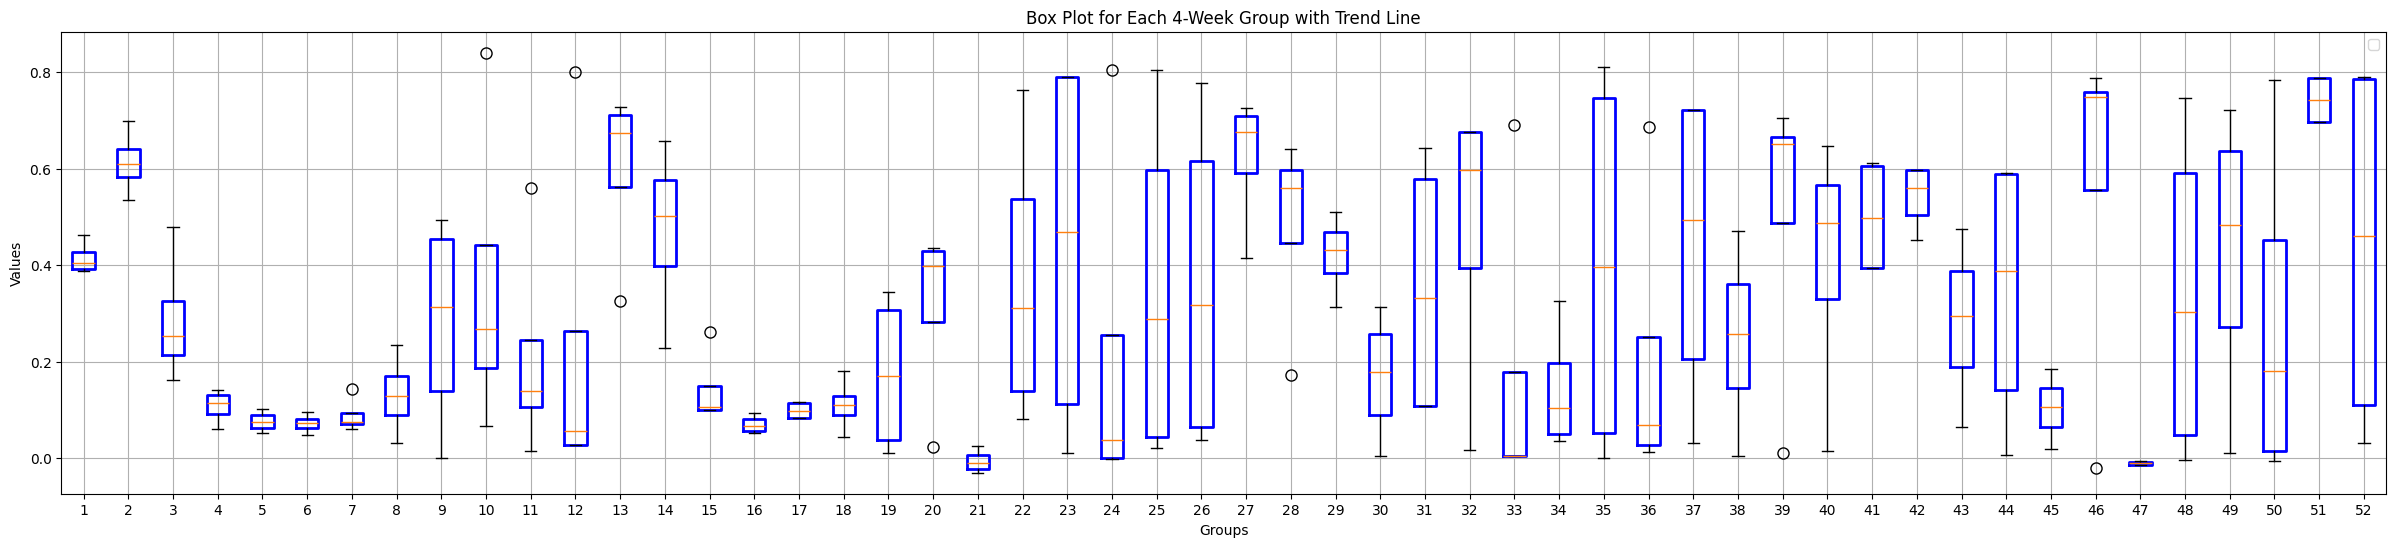

In [2]:
data = df['mean']
# Giả sử data là danh sách các giá trị và có cùng số lượng phần tử
# với tổng số tuần (data.shape[0] = total_weeks)

# Thiết lập số tuần trong mỗi nhóm
weeks_per_group = 4

# Tính số nhóm
num_groups = len(data) // weeks_per_group

# Tạo mảng để chứa dữ liệu cho các nhóm
grouped_data = []

for i in range(num_groups):
    start_index = i * weeks_per_group
    end_index = start_index + weeks_per_group
    grouped_data.append(data[start_index:end_index])

# Tạo box plot với màu
plt.figure(figsize=(30, 6))
boxprops = dict(color="blue", linewidth=2)
flierprops = dict(marker='o', color='red', markersize=8)

plt.boxplot(grouped_data, 
            labels=[f'{i+1}' for i in range(num_groups)],
            boxprops=boxprops, 
            flierprops=flierprops)



# Thêm tiêu đề và nhãn
plt.xlabel('Groups')
plt.ylabel('Values')
plt.title('Box Plot for Each 4-Week Group with Trend Line')
plt.legend()
plt.grid(True)
plt.show()


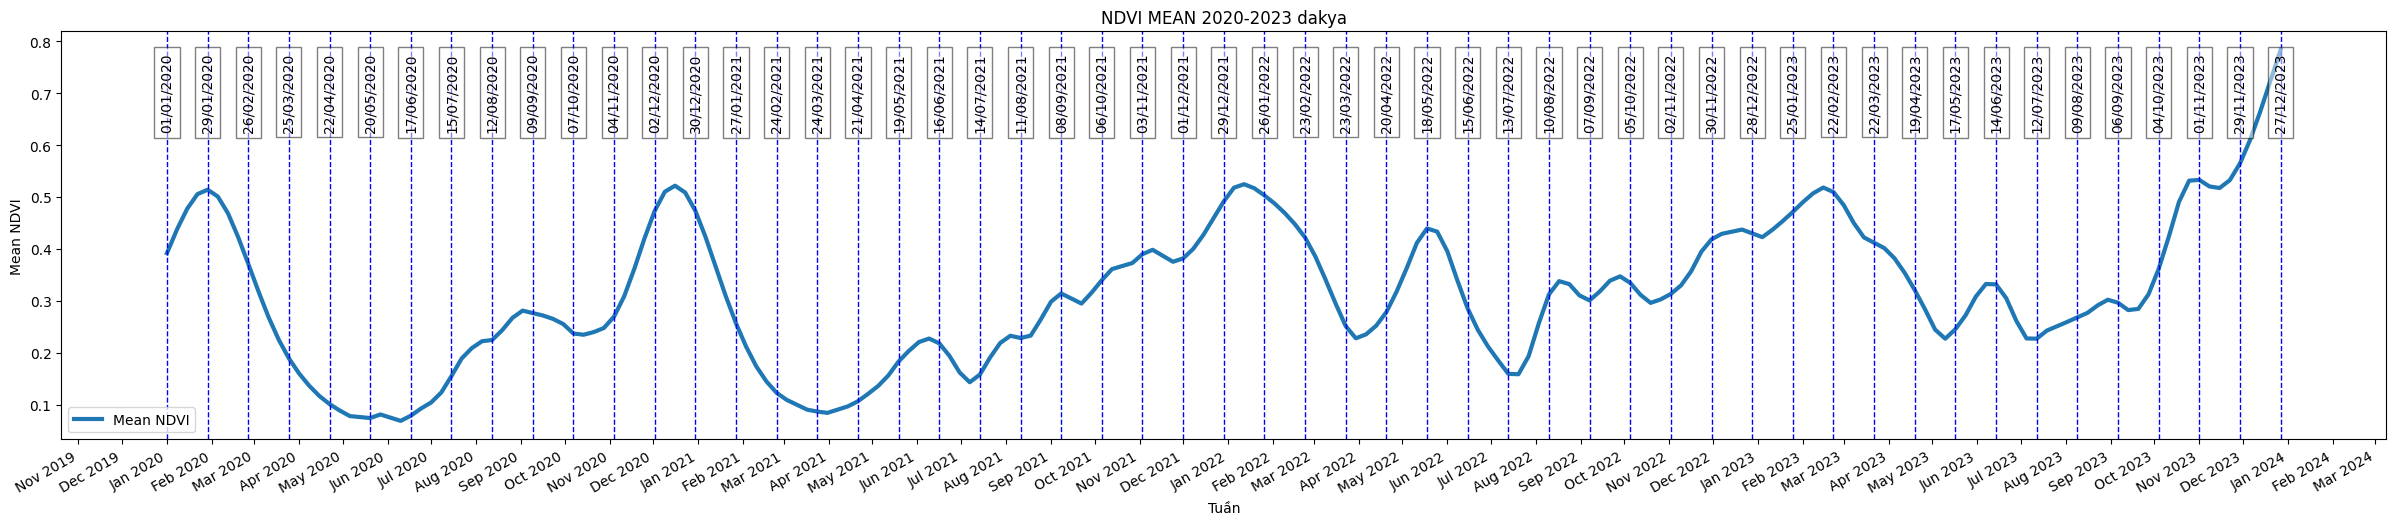

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Giả sử df là DataFrame của bạn và 'mean' là cột chứa dữ liệu NDVI
data = df['mean']

def adjust_outliers(arr, max_diff):
    # Sao chép mảng gốc để giữ nguyên mảng đầu vào
    result = arr[:]
    
    # Duyệt qua các phần tử từ vị trí 1 đến vị trí n-2
    for i in range(1, len(arr) - 1):
        # Tính sự thay đổi giữa phần tử hiện tại và phần tử trước/sau
        diff_before = abs(arr[i] - arr[i - 1])
        diff_after = abs(arr[i] - arr[i + 1])
        
        # Nếu phần tử hiện tại tăng hoặc giảm quá mức, điều chỉnh giá trị
        if diff_before > max_diff or diff_after > max_diff:
            # Điều chỉnh giá trị phần tử theo xu hướng
            result[i] = (arr[i - 1] + arr[i + 1]) / 2
            
    return result

# Điều chỉnh dữ liệu
new_data = adjust_outliers(data, 0.01)

# Xác định ngày bắt đầu và kết thúc
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 12, 31)

# Tạo danh sách các ngày thứ Hai (điểm bắt đầu tuần)
dates = [start_date + timedelta(weeks=i) for i in range(209)]

# Tạo nhãn cho từng tuần
labels = [date.strftime('%d/%m/%Y') for date in dates]

# Vẽ biểu đồ
plt.figure(figsize=(30, 6))
plt.plot(dates, new_data, linewidth=3, label='Mean NDVI')


# Thêm ngưỡng dọc và nhãn cho từng tuần
for i, date in enumerate(dates):
    if i % 4 == 0:  # Thay đổi tần suất nếu cần
        plt.axvline(x=date, color='blue', linestyle='--', linewidth=1)
        plt.text(date, plt.ylim()[1] * 0.95, labels[i], verticalalignment='top', horizontalalignment='center', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.5), rotation=90)

# Định dạng trục x với ngày
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()  # Xoay nhãn ngày

plt.xlabel("Tuần")
plt.ylabel("Mean NDVI")
plt.title("NDVI MEAN 2020-2023 dakya")
plt.legend()
plt.show()
